In [26]:
import datetime
import os.path as osp
import platform
import pickle as pkl

import matplotlib
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import global_mean_pool

from pyg_ssl.args import parse_args
from pyg_ssl.mlpf import MLPF
from pyg_ssl.training_mlpf import training_loop_mlpf
from pyg_ssl.training_VICReg import training_loop_VICReg
from pyg_ssl.utils import CLUSTERS_X, TRACKS_X, data_split, load_VICReg, save_MLPF, save_VICReg, distinguish_PFelements, combine_PFelements
from pyg_ssl.VICReg import DECODER, ENCODER

import tqdm
matplotlib.use("Agg")
mplhep.style.use(mplhep.styles.CMS)

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# define the global base device
if torch.cuda.device_count():
    device = torch.device("cuda:0")
    print(f"Will use {torch.cuda.get_device_name(device)}")
else:
    device = "cpu"
    print("Will use cpu")

Will use NVIDIA GeForce GTX 1080 Ti


In [27]:
# load the clic dataset
data_VICReg_train, data_VICReg_valid, data_mlpf_train, data_mlpf_valid, data_test_qcd, data_test_ttbar = data_split(
    "/pfclicvol/data/clic_edm4hep", "quick"
)

Will use data split mode `quick`
Will use 25843 events to train VICReg
Will use 2871 events to validate VICReg
Will use 6461 events to train MLPF
Will use 718 events to validate MLPF


In [28]:
embedding_dim_VICReg = 256
width_encoder = 256 
num_convs = 3
expand_dim = 256
width_decoder = 256

encoder_model_kwargs = {
    "embedding_dim": embedding_dim_VICReg,
    "width": width_encoder,
    "num_convs": num_convs,
    "space_dim": 4,
    "propagate_dim": 22,
    "k": 32,
}

decoder_model_kwargs = {
    "input_dim": embedding_dim_VICReg,
    "output_dim": expand_dim,
    "width": width_decoder,
}

encoder = ENCODER(**encoder_model_kwargs).to(device)
decoder = DECODER(**decoder_model_kwargs).to(device)

In [29]:
class VICReg(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(VICReg, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, tracks, clusters):

        ### encode
        embedding_tracks, embedding_clusters = self.encoder(tracks, clusters)
        
        ### decode
        out_tracks, out_clusters = self.decoder(embedding_tracks, embedding_clusters)

        return out_tracks, out_clusters

In [30]:
vicreg = VICReg(encoder, decoder)
vicreg

VICReg(
  (encoder): ENCODER(
    (nn1): Sequential(
      (0): Linear(in_features=14, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=256, out_features=256, bias=True)
    )
    (nn2): Sequential(
      (0): Linear(in_features=15, out_features=256, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv): ModuleList(
      (0): GravNetConv(256, 256, k=32)
      (1): GravNetConv(256, 256, k=32)
      (2): GravNetConv(256, 256, k=32)
    )
  )
  (decoder): DECODER(
    (expander): Sequential(
      (0): Linear(in_features=256, out_featur

In [31]:
batch_size_VICReg = 500
train_loader = torch_geometric.loader.DataLoader(data_VICReg_train, batch_size_VICReg)
valid_loader = torch_geometric.loader.DataLoader(data_VICReg_valid, batch_size_VICReg)

In [32]:
for batch in train_loader:
    # make transformation
    tracks, clusters = distinguish_PFelements(batch.to(device))

    # run through VICReg
    out_tracks, out_clusters = vicreg(tracks, clusters)

    # POOLING
    pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
    pooled_clusters = global_mean_pool(out_clusters, clusters.batch)
    break

In [33]:
F.mse_loss(pooled_tracks, pooled_clusters)

tensor(67.6493, device='cuda:0', grad_fn=<MseLossBackward0>)

In [34]:
class invar_loss(nn.Module):

    def __init__(self):
        super(invar_loss, self).__init__()

    def forward(self, x, y):
        return F.mse_loss(x, y)
    
class var_loss(nn.Module):

    def __init__(self):
        super(var_loss, self).__init__()

    def forward(self, x, y, epsilon=1e-3):
        std_x = torch.sqrt(x.var(dim=0) + epsilon)
        std_y = torch.sqrt(y.var(dim=0) + epsilon)
        var_loss = torch.mean(F.relu(1 - std_x)) + torch.mean(F.relu(1 - std_y))
        
        return var_loss    
    
class cross_loss(nn.Module):

    def __init__(self):
        super(cross_loss, self).__init__()

    def forward(self, x, y, lmbd=0.01):
        bs = x.size(0)
        emb = x.size(1)

        xNorm = (x - x.mean(0)) / x.std(0)
        yNorm = (y - y.mean(0)) / y.std(0)

        crossCorMat = (xNorm.T @ yNorm) / bs
        cross_loss = (crossCorMat * lmbd - torch.eye(emb, device=torch.device(device)) * lmbd).pow(2).sum()

        return cross_loss

In [35]:
crit_invar = invar_loss()
crit_var = var_loss()
crit_cross = cross_loss()

In [36]:
print(f"invar_loss = {crit_invar(pooled_tracks, pooled_clusters)}")
print(f"var_loss   = {crit_var(pooled_tracks, pooled_clusters)}")
print(f"cross_loss = {crit_cross(pooled_tracks, pooled_clusters)}")

invar_loss = 67.64934539794922
var_loss   = 0.9483171701431274
cross_loss = 0.029010634869337082


In [37]:
crit_invar = invar_loss()
crit_var = var_loss()
crit_cross = cross_loss()

import mdmm
max_ = 0.1

constraints = []
constraints.append(mdmm.MaxConstraint(lambda: crit_var(pooled_tracks, pooled_clusters), max_))
constraints.append(mdmm.MaxConstraint(lambda: crit_cross(pooled_tracks, pooled_clusters), max_))

# Train

In [42]:
encoder = ENCODER(**encoder_model_kwargs).to(device)
decoder = DECODER(**decoder_model_kwargs).to(device)
vicreg = VICReg(encoder, decoder)

mdmm_module = mdmm.MDMM(constraints)
opt = mdmm_module.make_optimizer(vicreg.parameters(), lr=2e-3)

optimizer = torch.optim.SGD(list(vicreg.parameters()), lr=2e-3)

In [43]:
mdmm_ = 0

n_epochs = 200
u = 0.01
v = 0.01
stale_epochs = 0
best_val_loss_tot = 99999999

# initialize loss counters
t_losses, v_losses = [], []
for j in range(n_epochs):
    
    # train loop
    is_train = True
    vicreg.train()
    loader = train_loader    
    losses, var_losses, invar_losses, cross_losses = 0.0, 0.0, 0.0, 0.0
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        # seperate tracks from clusters
        tracks, clusters = distinguish_PFelements(batch.to(device))
        # run VICReg
        out_tracks, out_clusters = vicreg(tracks, clusters)
        
        # POOLING
        pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
        pooled_clusters = global_mean_pool(out_clusters, clusters.batch)

        # compute loss & update parameters
        if mdmm_:
            loss = crit_invar(pooled_tracks, pooled_clusters)
            mdmm_return = mdmm_module(loss)            
            opt.zero_grad()
            mdmm_return.value.backward()
            opt.step()
        else:
            loss = u * crit_var(pooled_tracks, pooled_clusters) + v * crit_invar(pooled_tracks, pooled_clusters) + crit_cross(pooled_tracks, pooled_clusters)
            for param in vicreg.parameters():
                param.grad = None
            loss.backward()
            optimizer.step()            

        losses += loss.detach()

    t_losses.append(losses.cpu().item() / (len(loader)))

    # valid loop
    is_train = False
    vicreg.eval()
    loader = valid_loader
    losses = 0.0
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        # seperate tracks from clusters
        tracks, clusters = distinguish_PFelements(batch.to(device))
        # run VICReg
        out_tracks, out_clusters = vicreg(tracks, clusters)
        
        # POOLING
        pooled_tracks = global_mean_pool(out_tracks, tracks.batch)
        pooled_clusters = global_mean_pool(out_clusters, clusters.batch)

        # compute loss
        if mdmm_:
            loss = crit_invar(pooled_tracks, pooled_clusters)         
        else:
            loss = u * crit_var(pooled_tracks, pooled_clusters) + v * crit_invar(pooled_tracks, pooled_clusters) + crit_cross(pooled_tracks, pooled_clusters)

        losses += loss.detach()

    v_losses.append(losses.cpu().item() / (len(loader)))   
    
    if v_losses[j] < best_val_loss_tot:
        stale_epochs = 0
        best_val_loss_tot = v_losses[j]
        torch.save(vicreg.state_dict(), f"/pfclicvol/vicreg.pth")
    else:
        stale_epochs += 1
        
    print(f"{j}/{n_epochs} --- Train: tot_loss = {t_losses[j]:.2f} - Valid: tot_loss = {v_losses[j]:.2f} - stale={stale_epochs}") 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


0/200 --- Train: tot_loss = 1.19 - Valid: tot_loss = 0.08 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


1/200 --- Train: tot_loss = 0.08 - Valid: tot_loss = 0.07 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


2/200 --- Train: tot_loss = 0.07 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


3/200 --- Train: tot_loss = 0.07 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


4/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


5/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


6/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


7/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


8/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


9/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


10/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


11/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


12/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


13/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


14/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


15/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


16/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


17/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


18/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


19/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]


20/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


21/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


22/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.93it/s]


23/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.11it/s]


24/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


25/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


26/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


27/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


28/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


29/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


30/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


31/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


32/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


33/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


34/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


35/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


36/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


37/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


38/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


39/200 --- Train: tot_loss = 0.06 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


40/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


41/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


42/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


43/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


44/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


45/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


46/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


47/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


48/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


49/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


50/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


51/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


52/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


53/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


54/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


55/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


56/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


57/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


58/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


59/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


60/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


61/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


62/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


63/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


64/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


65/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


66/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


67/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


68/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


69/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


70/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


71/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


72/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


73/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


74/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


75/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


76/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


77/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


78/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


79/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


80/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


81/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


82/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


83/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


84/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


85/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


86/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


87/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


88/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


89/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


90/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


91/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


92/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


93/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


94/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


95/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


96/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


97/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


98/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


99/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


100/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


101/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


102/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


103/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


104/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


105/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


106/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


107/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


108/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


109/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


110/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


111/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


112/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


113/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


114/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


115/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


116/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


117/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


118/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


119/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


120/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


121/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


122/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


123/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


124/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


125/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.10it/s]


126/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


127/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


128/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


129/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


130/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


131/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


132/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


133/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


134/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


135/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


136/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


137/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


138/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


139/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


140/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


141/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


142/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.09it/s]


143/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]


144/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.08it/s]


145/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


146/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


147/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


148/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


149/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


150/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


151/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


152/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


153/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


154/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


155/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


156/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


157/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


158/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


159/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


160/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


161/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


162/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


163/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


164/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


165/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


166/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


167/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


168/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


169/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


170/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


171/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.02it/s]


172/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


173/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


174/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


175/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


176/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=18


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


177/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.90it/s]


178/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=20


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.92it/s]


179/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


180/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=22


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


181/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=23


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


182/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=24


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


183/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


184/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.98it/s]


185/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=27


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


186/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.04it/s]


187/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.00it/s]


188/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


189/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


190/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.07it/s]


191/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.05it/s]


192/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.95it/s]


193/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.03it/s]


194/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.01it/s]


195/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.97it/s]


196/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.06it/s]


197/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.99it/s]


198/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.94it/s]

199/200 --- Train: tot_loss = 0.05 - Valid: tot_loss = 0.06 - stale=1


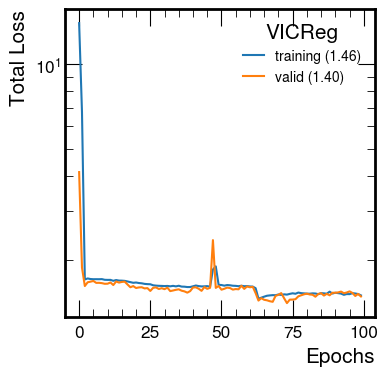

In [53]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))

result = np.mean(np.array(t_losses).reshape(-1, 2), axis=1)
ax.plot(range(len(result)), result, label="training ({:.2f})".format(result.min()))

result = np.mean(np.array(v_losses).reshape(-1, 2), axis=1)
ax.plot(range(len(result)), result, label="valid ({:.2f})".format(result.min()))

ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_yscale("log")
ax.legend(title="VICReg", loc="best", title_fontsize=15, fontsize=10)

In [43]:
torch.save(vicreg.state_dict(), f"/pfclicvol/vicreg.pth")

with open(f"/pfclicvol/vicreg_decoder_model_kwargs.pkl", "wb") as f:  # dump model architecture
    pkl.dump(decoder_model_kwargs, f, protocol=pkl.HIGHEST_PROTOCOL)
    
with open(f"/pfclicvol/vicreg_encoder_model_kwargs.pkl", "wb") as f:  # dump model architecture
    pkl.dump(encoder_model_kwargs, f, protocol=pkl.HIGHEST_PROTOCOL)    

In [57]:
tracks

DataBatch(x=[13641, 14], ygen=[13641, 5], ygen_id=[13641], ycand=[13641, 5], ycand_id=[13641], batch=[13641])

In [59]:
vicreg.encoder

ENCODER(
  (nn1): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (nn2): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (conv): ModuleList(
    (0): GravNetConv(256, 256, k=32)
    (1): GravNetConv(256, 256, k=32)
    (2): GravNetConv(256, 256, k=32)
  )
)

In [3]:
with open(f"/pfclicvol/vicreg_encoder_model_kwargs.pkl", "rb") as f:
    vicreg_encoder_model_kwargs = pkl.load(f)
with open(f"/pfclicvol/vicreg_decoder_model_kwargs.pkl", "rb") as f:
    vicreg_decoder_model_kwargs = pkl.load(f)        

In [6]:
encoder = ENCODER(**vicreg_encoder_model_kwargs)
decoder = DECODER(**vicreg_decoder_model_kwargs)

vicreg = VICReg(encoder, decoder)

In [14]:
vicreg_state_dict = torch.load(f"/pfclicvol/vicreg.pth", map_location=device)
vicreg.load_state_dict(vicreg_state_dict)

vicreg = vicreg.to(device)

In [15]:
print("------> Progressing to MLPF trainings...")
print(f"Will use {len(data_mlpf_train)} events for train")
print(f"Will use {len(data_mlpf_valid)} events for valid")

train_loader = torch_geometric.loader.DataLoader(data_mlpf_train, 500)
valid_loader = torch_geometric.loader.DataLoader(data_mlpf_valid, 500)

input_ = max(CLUSTERS_X, TRACKS_X) + 1  # max cz we pad when we concatenate them & +1 cz there's the `type` feature

------> Progressing to MLPF trainings...
Will use 6461 events for train
Will use 718 events for valid


In [16]:
import json
import math
import pickle as pkl
import time
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import Tensor, nn
from torch.nn import functional as F

matplotlib.use("Agg")

# Ignore divide by 0 errors
np.seterr(divide="ignore", invalid="ignore")

# keep track of the training step across epochs
istep_global = 0


# from https://github.com/AdeelH/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha: Optional[Tensor] = None, gamma: float = 0.0, reduction: str = "mean", ignore_index: int = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none", ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "ignore_index", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return torch.tensor(0.0)
        x = x[unignored_mask]

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss


def compute_weights(device, target_ids, num_classes):
    """
    computes necessary weights to accomodate class imbalance in the loss function
    """

    vs, cs = torch.unique(target_ids, return_counts=True)
    weights = torch.zeros(num_classes).to(device=device)
    for k, v in zip(vs, cs):
        weights[k] = 1.0 / math.sqrt(float(v))
    # weights[2] = weights[2] * 3  # emphasize nhadrons
    return weights


@torch.no_grad()
def validation_run(device, encoder, mlpf, train_loader, valid_loader, mode):
    with torch.no_grad():
        optimizer = None
        optimizer_VICReg = None
        ret = train(device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode)
    return ret


def train(device, encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode):
    """
    A training/validation run over a given epoch that gets called in the training_loop() function.
    When optimizer is set to None, it freezes the model for a validation_run.
    """

    is_train = not (optimizer is None)
    global istep_global

    loss_obj_id = FocalLoss(gamma=2.0)

    if is_train:
        print("---->Initiating a training run")
        mlpf.train()
        loader = train_loader
        if optimizer_VICReg:
            encoder.train()
    else:
        print("---->Initiating a validation run")
        mlpf.eval()
        loader = valid_loader
        if optimizer_VICReg:
            encoder.eval()

    # initialize loss counters
    epoch_loss_total, epoch_loss_id, epoch_loss_momentum, epoch_loss_charge = 0.0, 0.0, 0.0, 0.0

    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):

        if mode == "ssl":
            # seperate PF-elements
            tracks, clusters = distinguish_PFelements(batch.to(device))

            # ENCODE
            embedding_tracks, embedding_clusters = encoder(tracks, clusters)

            # concat the inputs with embeddings
            tracks.x = torch.cat([batch.x[batch.x[:, 0] == 1], embedding_tracks], axis=1)
            clusters.x = torch.cat([batch.x[batch.x[:, 0] == 2], embedding_clusters], axis=1)

            # combine PF-elements
            event = combine_PFelements(tracks, clusters)

        elif mode == "native":
            event = batch.to(device)

        # make mlpf forward pass
        event_on_device = event.to(device)
        pred_ids_one_hot, pred_momentum, pred_charge = mlpf(event_on_device)
        target_ids = event_on_device.ygen_id

        target_momentum = event_on_device.ygen[:, 1:].to(dtype=torch.float32)
        target_charge = (event_on_device.ygen[:, 0] + 1).to(dtype=torch.float32)  # -1, 0, 1

        loss_id = 100 * loss_obj_id(pred_ids_one_hot, target_ids)
        # loss_id_old = torch.nn.functional.cross_entropy(pred_ids_one_hot, target_ids)  # for classifying PID

        # for regression, mask the loss in cases there is no true particle
        msk_true_particle = torch.unsqueeze((target_ids != 0).to(dtype=torch.float32), axis=-1)
        loss_momentum = 10 * torch.nn.functional.huber_loss(
            pred_momentum * msk_true_particle, target_momentum * msk_true_particle
        )  # for regressing p4

        loss_charge = torch.nn.functional.cross_entropy(
            pred_charge * msk_true_particle, (target_charge * msk_true_particle[:, 0]).to(dtype=torch.int64)
        )  # for predicting charge
        loss = loss_id + loss_momentum + loss_charge

        if is_train:
            istep_global += 1

        # update parameters
        if is_train:
            for param in mlpf.parameters():
                param.grad = None
            if optimizer_VICReg:
                for param in encoder.parameters():
                    param.grad = None
            loss.backward()
            optimizer.step()

        epoch_loss_total += loss.detach()
        epoch_loss_id += loss_id.detach()
        epoch_loss_momentum += loss_momentum.detach()
        epoch_loss_charge += loss_charge.detach()

    epoch_loss_total = epoch_loss_total.cpu().item() / len(loader)
    epoch_loss_id = epoch_loss_id.cpu().item() / len(loader)
    epoch_loss_momentum = epoch_loss_momentum.cpu().item() / len(loader)
    epoch_loss_charge = epoch_loss_charge.cpu().item() / len(loader)

    print(
        "loss_id={:.2f} loss_momentum={:.2f} loss_charge={:.2f}".format(
            epoch_loss_id, epoch_loss_momentum, epoch_loss_charge
        )
    )
    return epoch_loss_total, epoch_loss_id, epoch_loss_momentum

In [44]:
embedding_dim_VICReg = 256
ssl = 1

mlpf_model_kwargs = {
    "input_dim": input_,
    "width": 256,
    "num_convs": 0,
    "dropout": 0.4,
    "ssl": ssl,
    "VICReg_embedding_dim": embedding_dim_VICReg
}

mlpf = MLPF(**mlpf_model_kwargs).to(device)
print(mlpf)

if ssl:
    mode = "ssl"
else:
    mode = "native"

MLPF(
  (nn_id): Sequential(
    (0): Linear(in_features=272, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ELU(alpha=1.0)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=256, bias=True)
    (13): ELU(alpha=1.0)
    (14): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (15): Linear(in_features=256, out_features=6, bias=True)
  )
  (nn_pt): Sequential(
    (0): Linear(in_features=278, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (3): Dropout

In [ ]:
n_epochs = 300
lr = 5e-5
patience = 50
FineTune_VICReg=False

# make mlpf specific directory
print(f"- Training {mode} MLPF over {n_epochs} epochs")

t0_initial = time.time()

losses_train_tot, losses_train_id, losses_train_momentum = [], [], []
losses_valid_tot, losses_valid_id, losses_valid_momentum = [], [], []

best_val_loss_tot, best_val_loss_id, best_val_loss_momentum = 99999.9, 99999.9, 99999.9
stale_epochs = 0

optimizer = torch.optim.AdamW(mlpf.parameters(), lr=lr)

# set VICReg to evaluation mode
vicreg.encoder.eval()
optimizer_VICReg = None

for epoch in range(n_epochs):
    t0 = time.time()

    if stale_epochs > patience:
        print("breaking due to stale epochs")
        break

    # training step
    losses_t_tot, losses_t_id, losses_t_momentum = train(
        device, vicreg.encoder, mlpf, train_loader, valid_loader, optimizer, optimizer_VICReg, mode
    )
    losses_train_tot.append(losses_t_tot)
    losses_train_id.append(losses_t_id)
    losses_train_momentum.append(losses_t_momentum)

    # validation step
    losses_v_tot, losses_v_id, losses_v_momentum = validation_run(
        device, vicreg.encoder, mlpf, train_loader, valid_loader, mode
    )
    losses_valid_tot.append(losses_v_tot)
    losses_valid_id.append(losses_v_id)
    losses_valid_momentum.append(losses_v_momentum)

    if losses_v_id < best_val_loss_id:
        best_val_loss_id = losses_v_id
        best_train_loss_id = losses_t_id

    if losses_v_momentum < best_val_loss_momentum:
        best_val_loss_momentum = losses_v_momentum
        best_train_loss_momentum = losses_t_momentum

    # early-stopping
    if losses_v_tot < best_val_loss_tot:
        best_val_loss_tot = losses_v_tot
        best_train_loss_tot = losses_t_tot

        stale_epochs = 0
    else:
        stale_epochs += 1

    t1 = time.time()

    epochs_remaining = n_epochs - (epoch + 1)
    time_per_epoch = (t1 - t0_initial) / (epoch + 1)
    eta = epochs_remaining * time_per_epoch / 60

    print(
        f"epoch={epoch + 1} / {n_epochs} "
        + f"train_loss={round(losses_train_tot[epoch], 4)} "
        + f"valid_loss={round(losses_valid_tot[epoch], 4)} "
        + f"stale={stale_epochs} "
        + f"time={round((t1-t0)/60, 2)}m "
        + f"eta={round(eta, 1)}m"
    )

    print("----------------------------------------------------------")
print(f"Done with training. Total training time is {round((time.time() - t0_initial)/60,3)}min")

- Training ssl MLPF over 300 epochs
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=75.06 loss_momentum=2.39 loss_charge=0.85
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=38.76 loss_momentum=1.78 loss_charge=0.64
epoch=1 / 300 train_loss=78.2951 valid_loss=41.1725 stale=0 time=0.77m eta=229.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=39.47 loss_momentum=2.11 loss_charge=0.66
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


loss_id=32.94 loss_momentum=1.77 loss_charge=0.64
epoch=2 / 300 train_loss=42.2301 valid_loss=35.3418 stale=0 time=0.78m eta=231.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=33.16 loss_momentum=2.07 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


loss_id=30.42 loss_momentum=1.76 loss_charge=0.63
epoch=3 / 300 train_loss=35.8689 valid_loss=32.8195 stale=0 time=0.8m eta=232.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=31.11 loss_momentum=2.05 loss_charge=0.64
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.91it/s]


loss_id=29.19 loss_momentum=1.76 loss_charge=0.63
epoch=4 / 300 train_loss=33.7933 valid_loss=31.5805 stale=0 time=0.78m eta=231.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=30.01 loss_momentum=2.04 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=28.44 loss_momentum=1.75 loss_charge=0.63
epoch=5 / 300 train_loss=32.6841 valid_loss=30.8203 stale=0 time=0.77m eta=230.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=29.30 loss_momentum=2.03 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.90it/s]


loss_id=27.94 loss_momentum=1.73 loss_charge=0.63
epoch=6 / 300 train_loss=31.9597 valid_loss=30.3071 stale=0 time=0.78m eta=229.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.16it/s]


loss_id=28.80 loss_momentum=2.02 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.99it/s]


loss_id=27.63 loss_momentum=1.71 loss_charge=0.63
epoch=7 / 300 train_loss=31.4511 valid_loss=29.978 stale=0 time=0.8m eta=229.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=28.41 loss_momentum=2.00 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=27.41 loss_momentum=1.70 loss_charge=0.63
epoch=8 / 300 train_loss=31.0473 valid_loss=29.7361 stale=0 time=0.77m eta=228.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.21it/s]


loss_id=28.13 loss_momentum=1.98 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


loss_id=27.22 loss_momentum=1.68 loss_charge=0.63
epoch=9 / 300 train_loss=30.7444 valid_loss=29.5291 stale=0 time=0.77m eta=227.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=27.90 loss_momentum=1.96 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=27.04 loss_momentum=1.66 loss_charge=0.63
epoch=10 / 300 train_loss=30.4921 valid_loss=29.3302 stale=0 time=0.78m eta=226.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=27.67 loss_momentum=1.94 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=26.83 loss_momentum=1.64 loss_charge=0.63
epoch=11 / 300 train_loss=30.2425 valid_loss=29.103 stale=0 time=0.78m eta=225.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=27.49 loss_momentum=1.92 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=26.62 loss_momentum=1.62 loss_charge=0.63
epoch=12 / 300 train_loss=30.0373 valid_loss=28.8738 stale=0 time=0.79m eta=225.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=27.29 loss_momentum=1.90 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


loss_id=26.39 loss_momentum=1.61 loss_charge=0.63
epoch=13 / 300 train_loss=29.8226 valid_loss=28.6276 stale=0 time=0.78m eta=224.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=27.12 loss_momentum=1.89 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.90it/s]


loss_id=26.14 loss_momentum=1.60 loss_charge=0.63
epoch=14 / 300 train_loss=29.6363 valid_loss=28.372 stale=0 time=0.8m eta=223.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=26.92 loss_momentum=1.88 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


loss_id=25.84 loss_momentum=1.60 loss_charge=0.63
epoch=15 / 300 train_loss=29.425 valid_loss=28.0679 stale=0 time=0.76m eta=222.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=26.70 loss_momentum=1.87 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=25.48 loss_momentum=1.59 loss_charge=0.63
epoch=16 / 300 train_loss=29.1987 valid_loss=27.7059 stale=0 time=0.77m eta=221.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=26.45 loss_momentum=1.86 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=25.08 loss_momentum=1.59 loss_charge=0.63
epoch=17 / 300 train_loss=28.9468 valid_loss=27.2952 stale=0 time=0.8m eta=221.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=26.18 loss_momentum=1.86 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=24.63 loss_momentum=1.59 loss_charge=0.63
epoch=18 / 300 train_loss=28.6636 valid_loss=26.8441 stale=0 time=0.77m eta=220.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=25.88 loss_momentum=1.85 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.00it/s]


loss_id=24.20 loss_momentum=1.58 loss_charge=0.63
epoch=19 / 300 train_loss=28.3602 valid_loss=26.4126 stale=0 time=0.79m eta=219.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=25.56 loss_momentum=1.85 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=23.73 loss_momentum=1.58 loss_charge=0.63
epoch=20 / 300 train_loss=28.0401 valid_loss=25.9373 stale=0 time=0.76m eta=218.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=25.20 loss_momentum=1.85 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=23.27 loss_momentum=1.58 loss_charge=0.63
epoch=21 / 300 train_loss=27.6781 valid_loss=25.4809 stale=0 time=0.77m eta=217.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=24.83 loss_momentum=1.84 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=22.86 loss_momentum=1.57 loss_charge=0.63
epoch=22 / 300 train_loss=27.3014 valid_loss=25.0647 stale=0 time=0.76m eta=216.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=24.48 loss_momentum=1.84 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.80it/s]


loss_id=22.51 loss_momentum=1.57 loss_charge=0.63
epoch=23 / 300 train_loss=26.9484 valid_loss=24.7175 stale=0 time=0.78m eta=215.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=24.14 loss_momentum=1.83 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=22.21 loss_momentum=1.57 loss_charge=0.63
epoch=24 / 300 train_loss=26.6089 valid_loss=24.4079 stale=0 time=0.76m eta=214.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=23.82 loss_momentum=1.83 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=21.95 loss_momentum=1.56 loss_charge=0.63
epoch=25 / 300 train_loss=26.2826 valid_loss=24.1493 stale=0 time=0.77m eta=214.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=23.51 loss_momentum=1.83 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.01it/s]


loss_id=21.73 loss_momentum=1.56 loss_charge=0.63
epoch=26 / 300 train_loss=25.9685 valid_loss=23.9195 stale=0 time=0.79m eta=213.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.21it/s]


loss_id=23.24 loss_momentum=1.82 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=21.52 loss_momentum=1.55 loss_charge=0.63
epoch=27 / 300 train_loss=25.6926 valid_loss=23.7023 stale=0 time=0.77m eta=212.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=22.96 loss_momentum=1.82 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


loss_id=21.35 loss_momentum=1.55 loss_charge=0.63
epoch=28 / 300 train_loss=25.4042 valid_loss=23.5275 stale=0 time=0.78m eta=211.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=22.73 loss_momentum=1.81 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=21.21 loss_momentum=1.54 loss_charge=0.63
epoch=29 / 300 train_loss=25.1753 valid_loss=23.3834 stale=0 time=0.8m eta=211.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.16it/s]


loss_id=22.55 loss_momentum=1.81 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=21.09 loss_momentum=1.54 loss_charge=0.63
epoch=30 / 300 train_loss=24.9844 valid_loss=23.2601 stale=0 time=0.8m eta=210.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=22.35 loss_momentum=1.80 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.77it/s]


loss_id=20.99 loss_momentum=1.53 loss_charge=0.63
epoch=31 / 300 train_loss=24.7874 valid_loss=23.1601 stale=0 time=0.76m eta=209.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.18it/s]


loss_id=22.20 loss_momentum=1.80 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=20.91 loss_momentum=1.53 loss_charge=0.63
epoch=32 / 300 train_loss=24.6232 valid_loss=23.073 stale=0 time=0.79m eta=208.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=22.07 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


loss_id=20.84 loss_momentum=1.52 loss_charge=0.63
epoch=33 / 300 train_loss=24.4877 valid_loss=22.9963 stale=0 time=0.8m eta=208.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=21.95 loss_momentum=1.79 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


loss_id=20.79 loss_momentum=1.52 loss_charge=0.63
epoch=34 / 300 train_loss=24.3633 valid_loss=22.9399 stale=0 time=0.77m eta=207.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=21.84 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=20.74 loss_momentum=1.51 loss_charge=0.63
epoch=35 / 300 train_loss=24.2503 valid_loss=22.8785 stale=0 time=0.78m eta=206.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=21.74 loss_momentum=1.78 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


loss_id=20.70 loss_momentum=1.51 loss_charge=0.63
epoch=36 / 300 train_loss=24.1478 valid_loss=22.8378 stale=0 time=0.79m eta=205.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=21.66 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


loss_id=20.66 loss_momentum=1.50 loss_charge=0.63
epoch=37 / 300 train_loss=24.0573 valid_loss=22.7958 stale=0 time=0.78m eta=205.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.21it/s]


loss_id=21.57 loss_momentum=1.77 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=20.62 loss_momentum=1.50 loss_charge=0.63
epoch=38 / 300 train_loss=23.9704 valid_loss=22.7505 stale=0 time=0.77m eta=204.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=21.50 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.60 loss_momentum=1.49 loss_charge=0.63
epoch=39 / 300 train_loss=23.8983 valid_loss=22.7232 stale=0 time=0.78m eta=203.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=21.45 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.74it/s]


loss_id=20.56 loss_momentum=1.49 loss_charge=0.63
epoch=40 / 300 train_loss=23.836 valid_loss=22.6853 stale=0 time=0.77m eta=202.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=21.38 loss_momentum=1.76 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.90it/s]


loss_id=20.54 loss_momentum=1.49 loss_charge=0.63
epoch=41 / 300 train_loss=23.7698 valid_loss=22.6525 stale=0 time=0.78m eta=201.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=21.33 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.84it/s]


loss_id=20.51 loss_momentum=1.48 loss_charge=0.63
epoch=42 / 300 train_loss=23.7083 valid_loss=22.6277 stale=0 time=0.78m eta=201.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=21.28 loss_momentum=1.75 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


loss_id=20.49 loss_momentum=1.48 loss_charge=0.63
epoch=43 / 300 train_loss=23.6533 valid_loss=22.5986 stale=0 time=0.77m eta=200.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=21.23 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.47 loss_momentum=1.48 loss_charge=0.63
epoch=44 / 300 train_loss=23.607 valid_loss=22.5773 stale=0 time=0.79m eta=199.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=21.19 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.45 loss_momentum=1.47 loss_charge=0.63
epoch=45 / 300 train_loss=23.5647 valid_loss=22.5521 stale=0 time=0.79m eta=198.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=21.15 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=20.43 loss_momentum=1.47 loss_charge=0.63
epoch=46 / 300 train_loss=23.5212 valid_loss=22.5327 stale=0 time=0.79m eta=198.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=21.12 loss_momentum=1.74 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.41 loss_momentum=1.47 loss_charge=0.63
epoch=47 / 300 train_loss=23.4808 valid_loss=22.5084 stale=0 time=0.76m eta=197.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=21.08 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


loss_id=20.39 loss_momentum=1.46 loss_charge=0.63
epoch=48 / 300 train_loss=23.4373 valid_loss=22.4887 stale=0 time=0.76m eta=196.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=21.04 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.37 loss_momentum=1.46 loss_charge=0.63
epoch=49 / 300 train_loss=23.4013 valid_loss=22.4666 stale=0 time=0.78m eta=195.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.18it/s]


loss_id=21.02 loss_momentum=1.73 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


loss_id=20.36 loss_momentum=1.46 loss_charge=0.63
epoch=50 / 300 train_loss=23.3727 valid_loss=22.448 stale=0 time=0.79m eta=194.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.99 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=20.34 loss_momentum=1.45 loss_charge=0.63
epoch=51 / 300 train_loss=23.3471 valid_loss=22.4279 stale=0 time=0.78m eta=194.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=20.96 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


loss_id=20.33 loss_momentum=1.45 loss_charge=0.63
epoch=52 / 300 train_loss=23.3129 valid_loss=22.4121 stale=0 time=0.77m eta=193.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=20.93 loss_momentum=1.72 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.04it/s]


loss_id=20.32 loss_momentum=1.44 loss_charge=0.63
epoch=53 / 300 train_loss=23.2767 valid_loss=22.3927 stale=0 time=0.77m eta=192.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.90 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  2.00it/s]


loss_id=20.30 loss_momentum=1.44 loss_charge=0.63
epoch=54 / 300 train_loss=23.2398 valid_loss=22.3738 stale=0 time=0.78m eta=191.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=20.88 loss_momentum=1.71 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.29 loss_momentum=1.43 loss_charge=0.63
epoch=55 / 300 train_loss=23.2129 valid_loss=22.3469 stale=0 time=0.76m eta=190.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.84 loss_momentum=1.70 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


loss_id=20.28 loss_momentum=1.41 loss_charge=0.63
epoch=56 / 300 train_loss=23.1705 valid_loss=22.321 stale=0 time=0.79m eta=190.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=20.84 loss_momentum=1.68 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


loss_id=20.26 loss_momentum=1.38 loss_charge=0.63
epoch=57 / 300 train_loss=23.1548 valid_loss=22.2798 stale=0 time=0.79m eta=189.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:45<00:00,  1.14it/s]


loss_id=20.80 loss_momentum=1.66 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=20.25 loss_momentum=1.35 loss_charge=0.63
epoch=58 / 300 train_loss=23.0948 valid_loss=22.2297 stale=0 time=0.82m eta=188.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=20.79 loss_momentum=1.63 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=20.23 loss_momentum=1.32 loss_charge=0.63
epoch=59 / 300 train_loss=23.0593 valid_loss=22.1881 stale=0 time=0.77m eta=187.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=20.77 loss_momentum=1.61 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.81it/s]


loss_id=20.22 loss_momentum=1.31 loss_charge=0.63
epoch=60 / 300 train_loss=23.0157 valid_loss=22.1584 stale=0 time=0.77m eta=187.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:45<00:00,  1.14it/s]


loss_id=20.74 loss_momentum=1.59 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=20.21 loss_momentum=1.29 loss_charge=0.63
epoch=61 / 300 train_loss=22.9635 valid_loss=22.1333 stale=0 time=0.81m eta=186.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=20.73 loss_momentum=1.57 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.97it/s]


loss_id=20.20 loss_momentum=1.28 loss_charge=0.63
epoch=62 / 300 train_loss=22.9328 valid_loss=22.1073 stale=0 time=0.76m eta=185.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:46<00:00,  1.13it/s]


loss_id=20.71 loss_momentum=1.56 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.00it/s]


loss_id=20.18 loss_momentum=1.27 loss_charge=0.63
epoch=63 / 300 train_loss=22.9025 valid_loss=22.0836 stale=0 time=0.82m eta=184.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:45<00:00,  1.13it/s]


loss_id=20.68 loss_momentum=1.54 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=20.17 loss_momentum=1.26 loss_charge=0.63
epoch=64 / 300 train_loss=22.8588 valid_loss=22.0627 stale=0 time=0.82m eta=184.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.67 loss_momentum=1.53 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=20.16 loss_momentum=1.25 loss_charge=0.63
epoch=65 / 300 train_loss=22.8363 valid_loss=22.0377 stale=0 time=0.79m eta=183.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.65 loss_momentum=1.52 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=20.14 loss_momentum=1.24 loss_charge=0.63
epoch=66 / 300 train_loss=22.7988 valid_loss=22.0162 stale=0 time=0.8m eta=182.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.65 loss_momentum=1.51 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


loss_id=20.13 loss_momentum=1.23 loss_charge=0.63
epoch=67 / 300 train_loss=22.7889 valid_loss=21.9968 stale=0 time=0.8m eta=182.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.62 loss_momentum=1.50 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.12 loss_momentum=1.22 loss_charge=0.63
epoch=68 / 300 train_loss=22.7516 valid_loss=21.968 stale=0 time=0.78m eta=181.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=20.60 loss_momentum=1.49 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=20.11 loss_momentum=1.21 loss_charge=0.63
epoch=69 / 300 train_loss=22.7202 valid_loss=21.9527 stale=0 time=0.78m eta=180.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.58 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


loss_id=20.09 loss_momentum=1.21 loss_charge=0.63
epoch=70 / 300 train_loss=22.696 valid_loss=21.9307 stale=0 time=0.79m eta=179.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.56 loss_momentum=1.48 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=20.08 loss_momentum=1.20 loss_charge=0.63
epoch=71 / 300 train_loss=22.6683 valid_loss=21.9112 stale=0 time=0.79m eta=179.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.55 loss_momentum=1.47 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=20.07 loss_momentum=1.19 loss_charge=0.63
epoch=72 / 300 train_loss=22.6459 valid_loss=21.8915 stale=0 time=0.79m eta=178.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:45<00:00,  1.14it/s]


loss_id=20.53 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


loss_id=20.05 loss_momentum=1.19 loss_charge=0.63
epoch=73 / 300 train_loss=22.6248 valid_loss=21.8721 stale=0 time=0.82m eta=177.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.16it/s]


loss_id=20.52 loss_momentum=1.46 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


loss_id=20.05 loss_momentum=1.18 loss_charge=0.63
epoch=74 / 300 train_loss=22.6024 valid_loss=21.8626 stale=0 time=0.8m eta=176.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.50 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.99it/s]


loss_id=20.04 loss_momentum=1.17 loss_charge=0.63
epoch=75 / 300 train_loss=22.58 valid_loss=21.8404 stale=0 time=0.79m eta=176.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.23it/s]


loss_id=20.50 loss_momentum=1.45 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.78it/s]


loss_id=20.02 loss_momentum=1.17 loss_charge=0.63
epoch=76 / 300 train_loss=22.5751 valid_loss=21.8221 stale=0 time=0.76m eta=175.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.47 loss_momentum=1.44 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


loss_id=20.02 loss_momentum=1.16 loss_charge=0.63
epoch=77 / 300 train_loss=22.5382 valid_loss=21.807 stale=0 time=0.8m eta=174.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.22it/s]


loss_id=20.46 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.90it/s]


loss_id=20.01 loss_momentum=1.15 loss_charge=0.63
epoch=78 / 300 train_loss=22.5263 valid_loss=21.7925 stale=0 time=0.77m eta=173.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.45 loss_momentum=1.43 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.83it/s]


loss_id=20.00 loss_momentum=1.14 loss_charge=0.63
epoch=79 / 300 train_loss=22.5102 valid_loss=21.7721 stale=0 time=0.79m eta=172.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.21it/s]


loss_id=20.44 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.87it/s]


loss_id=19.99 loss_momentum=1.14 loss_charge=0.63
epoch=80 / 300 train_loss=22.4934 valid_loss=21.7558 stale=0 time=0.77m eta=172.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.16it/s]


loss_id=20.42 loss_momentum=1.42 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.98 loss_momentum=1.13 loss_charge=0.63
epoch=81 / 300 train_loss=22.4644 valid_loss=21.7399 stale=0 time=0.8m eta=171.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.41 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.97 loss_momentum=1.13 loss_charge=0.63
epoch=82 / 300 train_loss=22.4462 valid_loss=21.7271 stale=0 time=0.8m eta=170.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.40 loss_momentum=1.41 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.00it/s]


loss_id=19.96 loss_momentum=1.12 loss_charge=0.63
epoch=83 / 300 train_loss=22.433 valid_loss=21.7124 stale=0 time=0.78m eta=169.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.38 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=19.95 loss_momentum=1.12 loss_charge=0.63
epoch=84 / 300 train_loss=22.4145 valid_loss=21.7023 stale=0 time=0.78m eta=169.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.36 loss_momentum=1.40 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


loss_id=19.94 loss_momentum=1.12 loss_charge=0.63
epoch=85 / 300 train_loss=22.392 valid_loss=21.6919 stale=0 time=0.78m eta=168.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.35 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=19.93 loss_momentum=1.11 loss_charge=0.63
epoch=86 / 300 train_loss=22.3778 valid_loss=21.6754 stale=0 time=0.78m eta=167.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:45<00:00,  1.14it/s]


loss_id=20.35 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.93 loss_momentum=1.11 loss_charge=0.63
epoch=87 / 300 train_loss=22.3675 valid_loss=21.6681 stale=0 time=0.81m eta=166.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=20.35 loss_momentum=1.39 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.02it/s]


loss_id=19.92 loss_momentum=1.11 loss_charge=0.63
epoch=88 / 300 train_loss=22.366 valid_loss=21.6604 stale=0 time=0.79m eta=166.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.32 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.92it/s]


loss_id=19.91 loss_momentum=1.10 loss_charge=0.63
epoch=89 / 300 train_loss=22.3347 valid_loss=21.6473 stale=0 time=0.78m eta=165.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.31 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.90 loss_momentum=1.10 loss_charge=0.63
epoch=90 / 300 train_loss=22.3205 valid_loss=21.6363 stale=0 time=0.78m eta=164.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.24it/s]


loss_id=20.31 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=19.90 loss_momentum=1.10 loss_charge=0.63
epoch=91 / 300 train_loss=22.3193 valid_loss=21.6282 stale=0 time=0.75m eta=163.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=20.30 loss_momentum=1.38 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.95it/s]


loss_id=19.89 loss_momentum=1.10 loss_charge=0.63
epoch=92 / 300 train_loss=22.3024 valid_loss=21.6163 stale=0 time=0.79m eta=162.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:42<00:00,  1.21it/s]


loss_id=20.28 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


loss_id=19.88 loss_momentum=1.10 loss_charge=0.63
epoch=93 / 300 train_loss=22.2868 valid_loss=21.6124 stale=0 time=0.77m eta=162.0m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:45<00:00,  1.13it/s]


loss_id=20.28 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.88it/s]


loss_id=19.87 loss_momentum=1.10 loss_charge=0.63
epoch=94 / 300 train_loss=22.2788 valid_loss=21.5998 stale=0 time=0.82m eta=161.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=20.26 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.87 loss_momentum=1.10 loss_charge=0.63
epoch=95 / 300 train_loss=22.2554 valid_loss=21.593 stale=0 time=0.78m eta=160.5m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.25 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.96it/s]


loss_id=19.86 loss_momentum=1.09 loss_charge=0.63
epoch=96 / 300 train_loss=22.2495 valid_loss=21.5847 stale=0 time=0.79m eta=159.7m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.20it/s]


loss_id=20.24 loss_momentum=1.37 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.85 loss_momentum=1.09 loss_charge=0.63
epoch=97 / 300 train_loss=22.2369 valid_loss=21.5754 stale=0 time=0.78m eta=158.9m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


loss_id=20.23 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=19.84 loss_momentum=1.09 loss_charge=0.63
epoch=98 / 300 train_loss=22.2241 valid_loss=21.5639 stale=0 time=0.78m eta=158.2m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.22 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.84 loss_momentum=1.09 loss_charge=0.63
epoch=99 / 300 train_loss=22.2081 valid_loss=21.5564 stale=0 time=0.79m eta=157.4m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.17it/s]


loss_id=20.21 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.86it/s]


loss_id=19.83 loss_momentum=1.09 loss_charge=0.63
epoch=100 / 300 train_loss=22.1974 valid_loss=21.5459 stale=0 time=0.79m eta=156.6m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.21it/s]


loss_id=20.20 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.94it/s]


loss_id=19.82 loss_momentum=1.09 loss_charge=0.63
epoch=101 / 300 train_loss=22.1908 valid_loss=21.5382 stale=0 time=0.77m eta=155.8m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.16it/s]


loss_id=20.19 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.91it/s]


loss_id=19.81 loss_momentum=1.09 loss_charge=0.63
epoch=102 / 300 train_loss=22.1812 valid_loss=21.5278 stale=0 time=0.8m eta=155.1m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.18it/s]


loss_id=20.18 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.89it/s]


loss_id=19.81 loss_momentum=1.09 loss_charge=0.63
epoch=103 / 300 train_loss=22.17 valid_loss=21.5226 stale=0 time=0.79m eta=154.3m
----------------------------------------------------------
---->Initiating a training run


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:44<00:00,  1.18it/s]


loss_id=20.17 loss_momentum=1.36 loss_charge=0.63
---->Initiating a validation run


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.93it/s]


loss_id=19.80 loss_momentum=1.08 loss_charge=0.63
epoch=104 / 300 train_loss=22.1549 valid_loss=21.5145 stale=0 time=0.79m eta=153.5m
----------------------------------------------------------
---->Initiating a training run


 21%|████████████████████▋                                                                             | 11/52 [00:09<00:33,  1.22it/s]

In [ ]:
losses_to_plot["old"] = {}

In [ ]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

losses_to_plot["old"]["tot"] = losses_valid_tot
losses_to_plot["old"]["id"] = losses_valid_id
losses_to_plot["old"]["p4"] = losses_valid_momentum

In [21]:
losses_to_plot = {}

In [22]:
losses_to_plot["ssl"] = {}

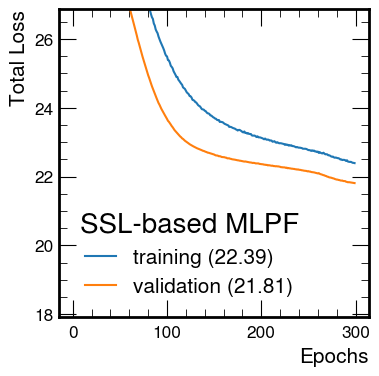

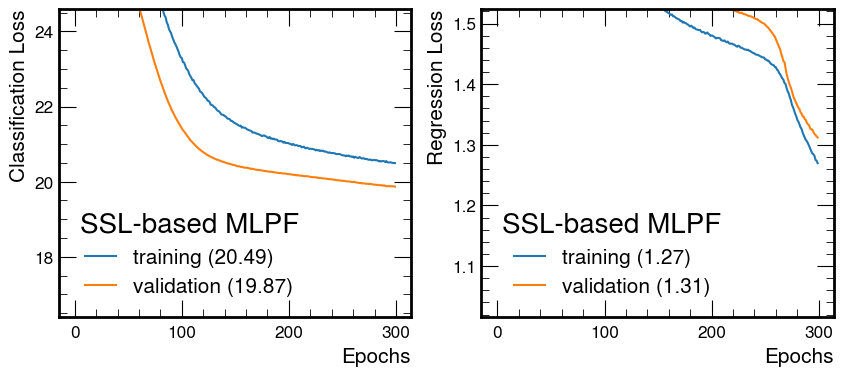

In [23]:
%matplotlib inline
plt.rcParams.update({"font.size": 15})

# make total loss plot
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(range(len(losses_train_tot)), losses_train_tot, label="training ({:.2f})".format(best_train_loss_tot))
ax.plot(range(len(losses_valid_tot)), losses_valid_tot, label="validation ({:.2f})".format(best_val_loss_tot))
ax.set_xlabel("Epochs")
ax.set_ylabel("Total Loss")
ax.set_ylim(0.8 * losses_train_tot[-1], 1.2 * losses_train_tot[-1])
if mode == "ssl":
    ax.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss id plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.plot(range(len(losses_train_id)), losses_train_id, label="training ({:.2f})".format(best_train_loss_id))
ax1.plot(range(len(losses_valid_id)), losses_valid_id, label="validation ({:.2f})".format(best_val_loss_id))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Classification Loss")
ax1.set_ylim(0.8 * losses_train_id[-1], 1.2 * losses_train_id[-1])
if mode == "ssl":
    ax1.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax1.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

# make loss momentum plot
ax2.plot(
    range(len(losses_train_momentum)),
    losses_train_momentum,
    label="training ({:.2f})".format(best_train_loss_momentum),
)
ax2.plot(
    range(len(losses_valid_momentum)),
    losses_valid_momentum,
    label="validation ({:.2f})".format(best_val_loss_momentum),
)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Regression Loss")
ax2.set_ylim(0.8 * losses_train_momentum[-1], 1.2 * losses_train_momentum[-1])
if mode == "ssl":
    ax2.legend(title="SSL-based MLPF", loc="best", title_fontsize=20, fontsize=15)
else:
    ax2.legend(title="Native MLPF", loc="best", title_fontsize=20, fontsize=15)

losses_to_plot["ssl"]["tot"] = losses_valid_tot
losses_to_plot["ssl"]["id"] = losses_valid_id
losses_to_plot["ssl"]["p4"] = losses_valid_momentum

# Other